In [1]:
# Relative imports outside of package
import sys
import os
sys.path.insert(1, os.path.join(sys.path[0], '../..'))

import torch
import torch.nn as nn
import matplotlib.pyplot as plt

from levers import IteratedLeverEnvironment
from levers.partners import FixedPatternPartner
from levers.learner import DRQNAgent
from levers.helpers import eval_drqn_agents, generate_binary_patterns

import itertools

In [2]:
# Environment settings
payoffs = [1., 1.]
truncated_length = 100
include_step=False
include_payoffs=False

# Learner settings
hidden_size = 4
capacity = 8
batch_size = 4
lr = 0.01
gamma = 0.99
len_update_cycle = 4
tau = 5e-4

n_train_evals = 10

# Model settings
models_dir = 'models'
model_name_template = 'drqn-net-train-patterns={train_patterns}-eval-id={eval_id:02d}.pt'


class DRQNetwork(nn.Module):

    def __init__(self, input_size, hidden_size, n_actions):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            batch_first=True,
        )
        self.lin1 = nn.Linear(in_features=hidden_size, out_features=hidden_size)
        self.relu = nn.ReLU()
        self.lin2 = nn.Linear(in_features=hidden_size, out_features=n_actions)

    def forward(self, input, hidden=None):
        # input shape: (batch_size, seq_length, input_size)
        # lstm_out shape: (batch_size, seq_length, hidden_size)
        # out shape: (batch_size, seq_length, n_actions)
        lstm_out, lstm_hid = self.lstm(input, hidden)
        temp = self.relu(self.lin1(lstm_out))
        return self.lin2(temp), lstm_hid

In [7]:
# Begin experiment
patterns = generate_binary_patterns(3)

# Construct list of environments to evaluate DRQN agent in
eval_envs = [
    IteratedLeverEnvironment(
        payoffs, truncated_length+1, FixedPatternPartner(list(pattern)),
        include_step, include_payoffs)
    for pattern in [(0, 0, 0), (1, 1, 1)]
]

total_res = {}
for train_patterns_id, train_patterns in enumerate(list(itertools.combinations(patterns, 4))):
    print(f'TRAIN-PATTERNS ({train_patterns_id+1:2d}/70): {train_patterns}')

    # Initialize and load DRQN agents
    agents = [
        DRQNAgent(
            DRQNetwork(
                input_size=len(eval_envs[0].dummy_obs()),
                hidden_size=hidden_size,
                n_actions=eval_envs[0].n_actions()
            ),
            capacity, batch_size, lr, gamma, len_update_cycle, tau
        )
        for agent_id in range(n_train_evals)
    ]

    # Load agents' q networks 
    for agent_id in range(n_train_evals):
        in_path = os.path.join(models_dir, model_name_template.format(
            train_patterns=train_patterns,
            eval_id=agent_id,
        ))
        agents[agent_id].q_net =torch.load(in_path)

    # Evaluate agent
    res = eval_drqn_agents(agents, eval_envs, True)
    total_res[train_patterns] = res['rewards'].sum(dim=(0, 2))

TRAIN-PATTERNS ( 1/70): ((0, 0, 0), (0, 0, 1), (0, 1, 0), (0, 1, 1))
TRAIN-PATTERNS ( 2/70): ((0, 0, 0), (0, 0, 1), (0, 1, 0), (1, 0, 0))
TRAIN-PATTERNS ( 3/70): ((0, 0, 0), (0, 0, 1), (0, 1, 0), (1, 0, 1))
TRAIN-PATTERNS ( 4/70): ((0, 0, 0), (0, 0, 1), (0, 1, 0), (1, 1, 0))
TRAIN-PATTERNS ( 5/70): ((0, 0, 0), (0, 0, 1), (0, 1, 0), (1, 1, 1))
TRAIN-PATTERNS ( 6/70): ((0, 0, 0), (0, 0, 1), (0, 1, 1), (1, 0, 0))
TRAIN-PATTERNS ( 7/70): ((0, 0, 0), (0, 0, 1), (0, 1, 1), (1, 0, 1))
TRAIN-PATTERNS ( 8/70): ((0, 0, 0), (0, 0, 1), (0, 1, 1), (1, 1, 0))
TRAIN-PATTERNS ( 9/70): ((0, 0, 0), (0, 0, 1), (0, 1, 1), (1, 1, 1))
TRAIN-PATTERNS (10/70): ((0, 0, 0), (0, 0, 1), (1, 0, 0), (1, 0, 1))
TRAIN-PATTERNS (11/70): ((0, 0, 0), (0, 0, 1), (1, 0, 0), (1, 1, 0))
TRAIN-PATTERNS (12/70): ((0, 0, 0), (0, 0, 1), (1, 0, 0), (1, 1, 1))
TRAIN-PATTERNS (13/70): ((0, 0, 0), (0, 0, 1), (1, 0, 1), (1, 1, 0))
TRAIN-PATTERNS (14/70): ((0, 0, 0), (0, 0, 1), (1, 0, 1), (1, 1, 1))
TRAIN-PATTERNS (15/70): ((0, 0, 0)

In [12]:
zeros_res_view = [(value[0].item(), train_patterns) for train_patterns, value in total_res.items()]
ones_res_view = [(value[1].item(), train_patterns) for train_patterns, value in total_res.items()]
zeros_res_view.sort(reverse=True)
ones_res_view.sort(reverse=True)

In [56]:
for ret, tps in zeros_res_view:
    print('Train-patterns: {tp}, N-Zeros ({n_overall} | {n0}, {n1}, {n2}), Return: {ret:1.3f}'.format(
        tp=tps,
        n_overall=12 - sum([sum(p) for p in tps]),
        n0=4 - sum([p[0] for p in tps]),
        n1=4 - sum([p[1]  for p in tps]),
        n2=4 - sum([p[2] for p in tps]),
        ret=ret / (n_train_evals * truncated_length)
    ))

Train-patterns: ((0, 0, 0), (0, 0, 1), (0, 1, 0), (1, 1, 0)), N-Zeros (8 | 3, 2, 3), Return: 1.000
Train-patterns: ((0, 0, 0), (0, 0, 1), (0, 1, 0), (1, 1, 1)), N-Zeros (7 | 3, 2, 2), Return: 0.998
Train-patterns: ((0, 0, 0), (0, 0, 1), (0, 1, 0), (1, 0, 1)), N-Zeros (8 | 3, 3, 2), Return: 0.998
Train-patterns: ((0, 0, 0), (0, 0, 1), (0, 1, 0), (1, 0, 0)), N-Zeros (9 | 3, 3, 3), Return: 0.998
Train-patterns: ((0, 0, 0), (0, 0, 1), (0, 1, 1), (1, 1, 0)), N-Zeros (7 | 3, 2, 2), Return: 0.997
Train-patterns: ((0, 0, 0), (0, 0, 1), (1, 0, 0), (1, 1, 1)), N-Zeros (7 | 2, 3, 2), Return: 0.996
Train-patterns: ((0, 0, 0), (0, 1, 0), (0, 1, 1), (1, 0, 0)), N-Zeros (8 | 3, 2, 3), Return: 0.995
Train-patterns: ((0, 0, 0), (0, 0, 1), (1, 0, 1), (1, 1, 0)), N-Zeros (7 | 2, 3, 2), Return: 0.995
Train-patterns: ((0, 0, 0), (0, 1, 0), (1, 0, 0), (1, 1, 1)), N-Zeros (7 | 2, 2, 3), Return: 0.994
Train-patterns: ((0, 0, 0), (0, 0, 1), (1, 1, 0), (1, 1, 1)), N-Zeros (6 | 2, 2, 2), Return: 0.994
Train-patt

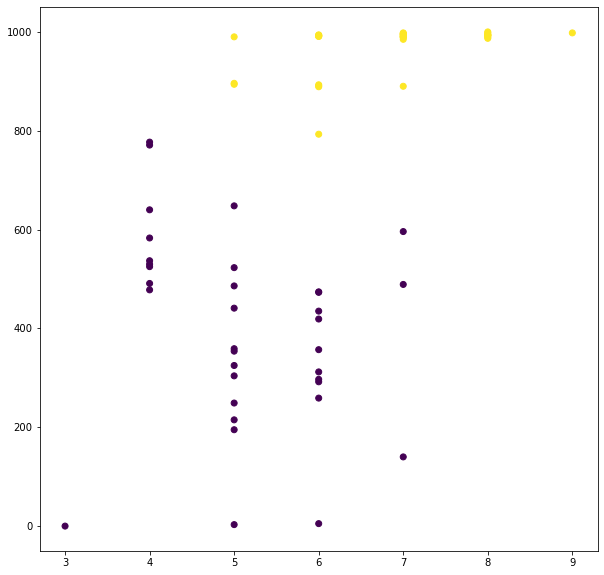

In [64]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.scatter(
    [12 - sum([sum(p) for p in tp]) for _, tp in zeros_res_view],
    [ret for ret, tp in zeros_res_view],
    c = [(0, 0, 0) in tp for _, tp in zeros_res_view],
)
plt.show()

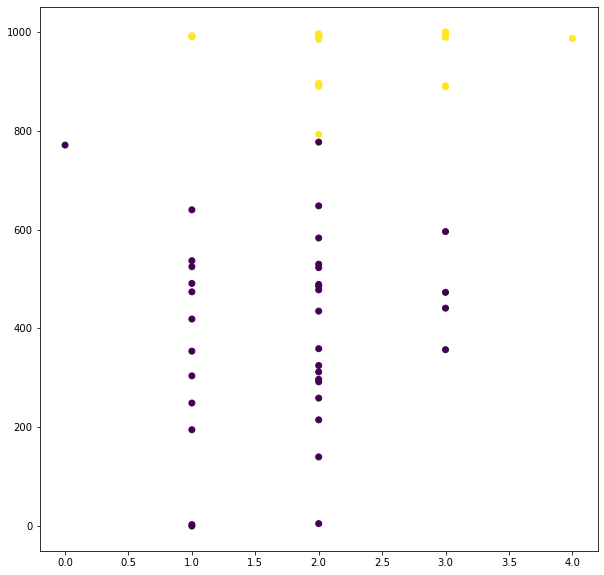

In [66]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.scatter(
    [4 - sum([p[0] for p in tp]) for _, tp in zeros_res_view],
    [ret for ret, _ in zeros_res_view],
    c = [(0, 0, 0) in tp for _, tp in zeros_res_view],
)
plt.show()

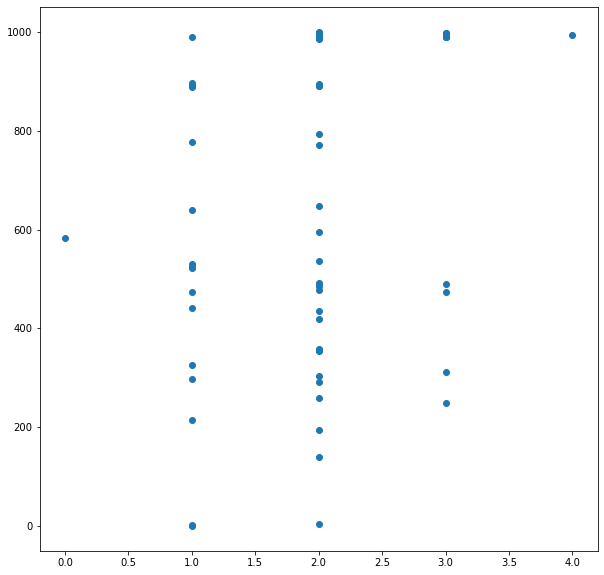

In [69]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.scatter(
    [4 - sum([p[1] for p in tp]) for _, tp in zeros_res_view],
    [ret for ret, _ in zeros_res_view],
)
plt.show()

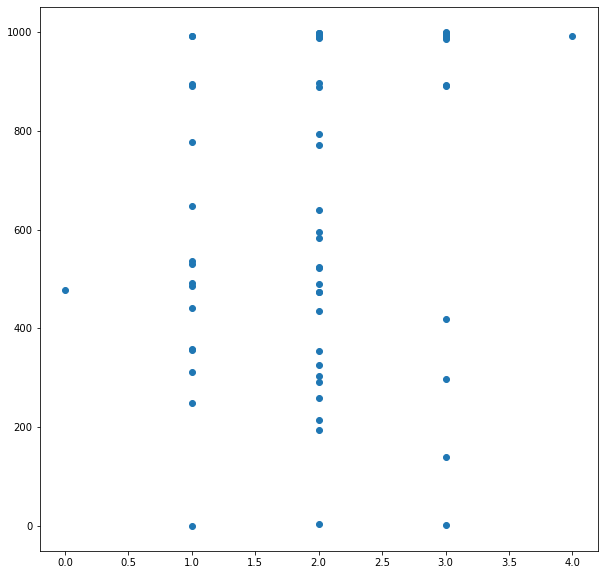

In [50]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.scatter(
    [4 - sum([p[2] for p in tp]) for _, tp in zeros_res_view],
    [ret for ret, _ in zeros_res_view],
)
plt.show()

In [57]:
for ret, tps in ones_res_view:
    print('Train-patterns: {tp}, N-Ones ({n_overall} | {n0}, {n1}, {n2}), Return: {ret:1.3f}'.format(
        tp=tps,
        n_overall=sum([sum(p) for p in tps]),
        n0=sum([p[0] for p in tps]),
        n1=sum([p[1]  for p in tps]),
        n2=sum([p[2] for p in tps]),
        ret=ret / (n_train_evals * truncated_length)
    ))

Train-patterns: ((0, 1, 0), (1, 0, 1), (1, 1, 0), (1, 1, 1)), N-Ones (8 | 3, 3, 2), Return: 0.998
Train-patterns: ((0, 1, 1), (1, 0, 0), (1, 1, 0), (1, 1, 1)), N-Ones (8 | 3, 3, 2), Return: 0.997
Train-patterns: ((0, 1, 0), (1, 0, 0), (1, 1, 0), (1, 1, 1)), N-Ones (7 | 3, 3, 1), Return: 0.997
Train-patterns: ((0, 0, 0), (1, 0, 1), (1, 1, 0), (1, 1, 1)), N-Ones (7 | 3, 2, 2), Return: 0.997
Train-patterns: ((0, 0, 1), (0, 1, 0), (1, 1, 0), (1, 1, 1)), N-Ones (7 | 2, 3, 2), Return: 0.995
Train-patterns: ((0, 1, 1), (1, 0, 0), (1, 0, 1), (1, 1, 1)), N-Ones (8 | 3, 2, 3), Return: 0.994
Train-patterns: ((0, 1, 0), (0, 1, 1), (1, 1, 0), (1, 1, 1)), N-Ones (8 | 2, 4, 2), Return: 0.994
Train-patterns: ((0, 1, 0), (0, 1, 1), (1, 0, 0), (1, 1, 1)), N-Ones (7 | 2, 3, 2), Return: 0.994
Train-patterns: ((0, 0, 1), (1, 0, 0), (1, 1, 0), (1, 1, 1)), N-Ones (7 | 3, 2, 2), Return: 0.994
Train-patterns: ((1, 0, 0), (1, 0, 1), (1, 1, 0), (1, 1, 1)), N-Ones (8 | 4, 2, 2), Return: 0.993
Train-patterns: ((0,

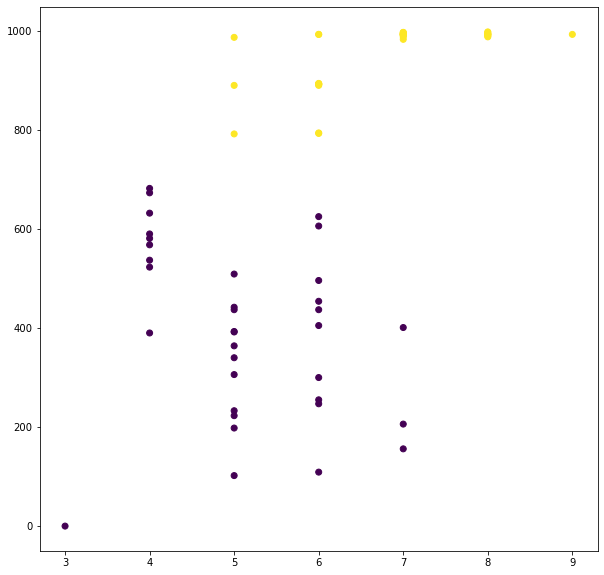

In [65]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.scatter(
    [sum([sum(p) for p in tp]) for _, tp in ones_res_view],
    [ret for ret, tp in ones_res_view],
    c = [(1, 1, 1) in tp for _, tp in ones_res_view],
)
plt.show()

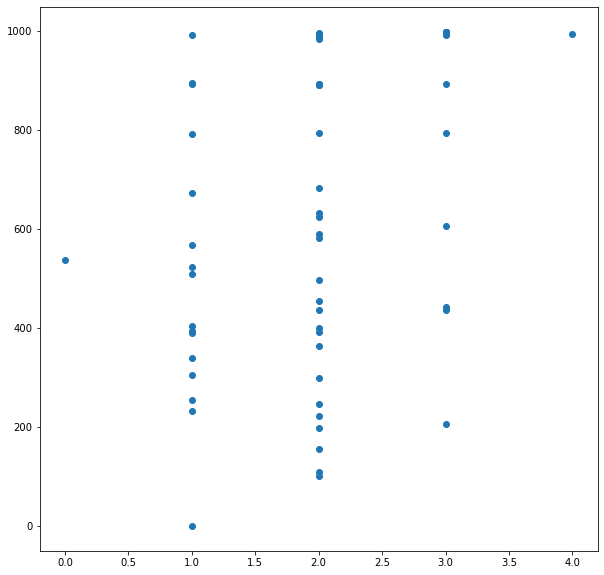

In [68]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.scatter(
    [sum([p[0] for p in tp]) for _, tp in ones_res_view],
    [ret for ret, _ in ones_res_view],
)
plt.show()

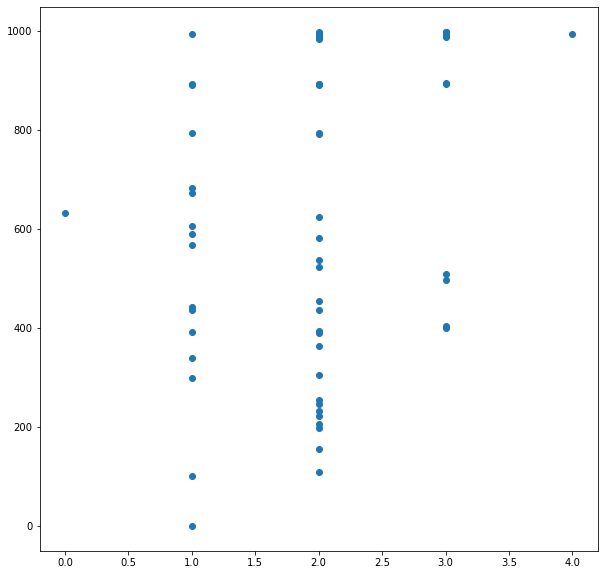

In [52]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.scatter(
    [sum([p[1] for p in tp]) for _, tp in ones_res_view],
    [ret for ret, _ in ones_res_view],
)
plt.show()

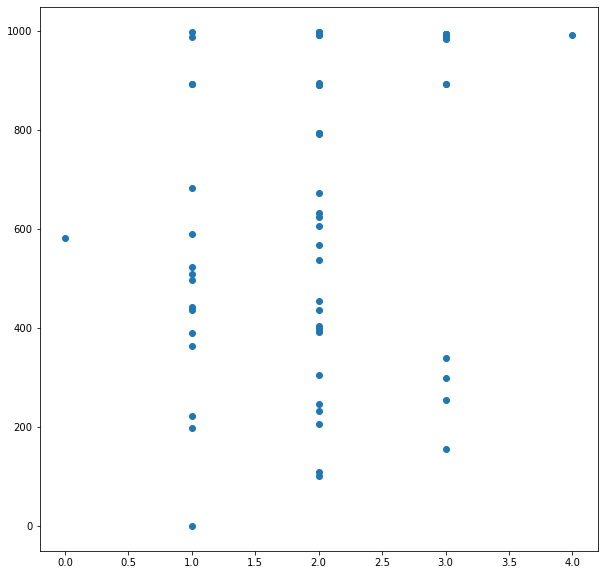

In [53]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.scatter(
    [sum([p[2] for p in tp]) for _, tp in ones_res_view],
    [ret for ret, _ in ones_res_view],
)
plt.show()